In [4]:
  !unzip /kaggle/input/dogs-vs-cats/train.zip

Archive:  /kaggle/input/dogs-vs-cats/train.zip
   creating: train/
  inflating: train/cat.0.jpg         
  inflating: train/cat.1.jpg         
  inflating: train/cat.10.jpg        
  inflating: train/cat.100.jpg       
  inflating: train/cat.1000.jpg      
  inflating: train/cat.10000.jpg     
  inflating: train/cat.10001.jpg     
  inflating: train/cat.10002.jpg     
  inflating: train/cat.10003.jpg     
  inflating: train/cat.10004.jpg     
  inflating: train/cat.10005.jpg     
  inflating: train/cat.10006.jpg     
  inflating: train/cat.10007.jpg     
  inflating: train/cat.10008.jpg     
  inflating: train/cat.10009.jpg     
  inflating: train/cat.1001.jpg      
  inflating: train/cat.10010.jpg     
  inflating: train/cat.10011.jpg     
  inflating: train/cat.10012.jpg     
  inflating: train/cat.10013.jpg     
  inflating: train/cat.10014.jpg     
  inflating: train/cat.10015.jpg     
  inflating: train/cat.10016.jpg     
  inflating: train/cat.10017.jpg     
  inflating: train/ca

In [5]:
import os
import sys
import random 
import torch 
import torchvision 
from PIL import Image 
import torch.nn as nn 
import matplotlib.pyplot as plt 
from torchvision import models
from torchvision.transforms import v2
from torch.utils.data import Dataset , DataLoader 

In [6]:
train_path = '/kaggle/working/train'
all_paths = os.listdir(train_path)
cat_paths = [path for path in all_paths if path.startswith('cat')]
dog_paths = [path for path in all_paths if path.startswith('dog')]

train_paths = cat_paths[2500:] + dog_paths[2500:]
val_paths = cat_paths[:2500] + dog_paths[:2500]

In [7]:
random.seed(42)
random.shuffle(train_paths)
random.shuffle(val_paths)

In [8]:
print(len(all_paths))
print(len(cat_paths))
print(len(dog_paths))

25000
12500
12500


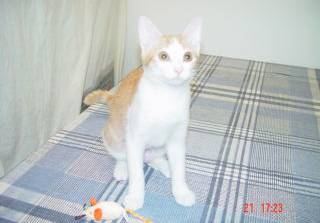

In [9]:
example_with_cat = os.path.join(train_path , cat_paths[2])
Image.open(example_with_cat)

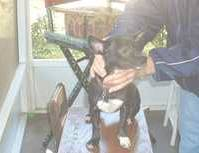

In [10]:
ex_with_dog = os.path.join(train_path , dog_paths[2])
Image.open(ex_with_dog)

In [11]:
train_transform = v2.Compose(
[
  v2.PILToTensor(),
  v2.RandomHorizontalFlip(p = 0.5),
  v2.RandomVerticalFlip(p = 0.5),  
  v2.RandomResizedCrop(size = [227, 227], antialias = True),  
  v2.ToDtype(torch.float32, scale = True),
  v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])  # for resnet
]
)

val_transform = v2.Compose(
[
  v2.PILToTensor(),
  v2.ToDtype(torch.float32, scale = True),
  v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])  # for resnet
  
]
)

transform = {
    "train_transform": train_transform,
    "val_transform": val_transform
}

In [12]:
class dataset(Dataset):
    def __init__(self, paths, transform = None, is_train = True) :
        self.paths = paths
        self.transform = transform
        self.is_train = is_train
        
    
    def __getitem__(self, index):
        full_path = os.path.join(train_path, self.paths[index])
        img = Image.open(full_path)
        img = img.resize((227, 227))
        label = self.paths[index][:3]
        
        if self.transform:
            if self.is_train:
                img = self.transform["train_transform"](img)
            else:
                img = self.transform["val_transform"](img)
            
        
        return img, int(label == "cat")
    
    def __len__(self):
        return len(self.paths)

In [13]:
train_data = dataset(train_paths, transform)
val_data = dataset(val_paths, transform, is_train = False)

In [14]:
train_data[2][0].shape

torch.Size([3, 227, 227])

In [15]:
train_loader = DataLoader(train_data , shuffle = True , batch_size= 32)
val_loader = DataLoader(val_data , shuffle = True , batch_size= 32)

In [16]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 227, 227])

In [17]:
next(iter(train_loader))[1]

tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 1])

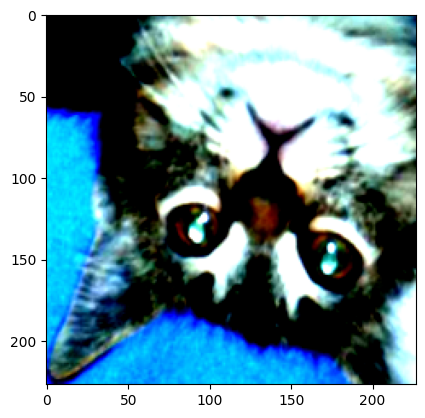

In [18]:
img = train_data[0][0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [19]:
train_data[0][1]

1

# implement AlexNet architecture

In [20]:
#  class AlexNet(nn.Module):
#     def __init__(self, num_classes):
#         super(AlexNet, self).__init__()
        
#         self.conv1 = nn.Conv2d(3, 96, kernel_size = 11, stride = 4)
#         self.mx1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
#         self.conv2 = nn.Conv2d(96, 256, kernel_size = 5, padding = "same")
#         self.mx2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
#         self.conv3 = nn.Conv2d(256, 384, kernel_size = 3, padding = "same")
#         self.conv4 = nn.Conv2d(384, 384, kernel_size = 3, padding = "same")
#         self.conv5 = nn.Conv2d(384, 256, kernel_size = 3, padding = "same")
        
#         self.mx3 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
#         self.linear1 = nn.Linear(9216, 4096)
#         self.linear2 = nn.Linear(4096, 4096)
#         self.linear3 = nn.Linear(4096, num_classes)
        
#     def forward(self, x):
        
#         out = nn.ReLU()(self.conv1(x))
#         out = self.mx1(out)
#         out = self.mx2(nn.ReLU()(self.conv2(out)))
#         out = nn.ReLU()(self.conv3(out))
#         out = nn.ReLU()(self.conv4(out))
#         out = nn.ReLU()(self.conv5(out))
#         out = self.mx3(out)
#         out = nn.Flatten()(out)
#         out = nn.ReLU()(self.linear1(out))
#         out = nn.ReLU()(self.linear2(out))
#         out = self.linear3(out)

#         return out

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

In [22]:
# model = AlexNet(2).to(device)

transfer learning

In [23]:
# load the model
model = models.resnet50(weights = "IMAGENET1K_V1")

# freeze the model
for parameter in model.parameters():
    parameter.requires_grad = False
    
# change classification head
model.fc = nn.Linear(model.fc.in_features, 2)

# move model to cuda
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
num_epochs = 3
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [25]:
def train_epoch():
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        out = model(images)
        loss = criterion(out, labels)
        epoch_loss += loss
        
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i%32 ==0):
            print(f"   batch[{i+1} / {len(train_loader)}]")
    print('')       
    return epoch_loss / len(train_loader)

In [26]:
def get_val_loss():
    epoch_loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):

            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            out = model(images)
            loss = criterion(out, labels)
            epoch_loss += loss
            
    return epoch_loss / len(val_loader)

In [27]:
train_losses = []
val_losses = []
best_score = float("inf")
tolerance = 0

for epoch in range(num_epochs):
    print(f"epoch {epoch+1}:")
    
    model.train(True)
    avg_train_epoch_loss = train_epoch()
    
    model.eval()
    avg_val_epoch_loss = get_val_loss()
    
    if(avg_val_epoch_loss < best_score):
        print(f'the model improving from {best_score:.3f} to {avg_val_epoch_loss:.3f}')
        best_score = avg_val_epoch_loss
        torch.save(model.state_dict(), f"Best_model.pt")
    
    else:
        print('the model didn\'t improving')
        tolerance += 1
        if(tolerance == 2):
            break
            
    train_losses.append(avg_train_epoch_loss)
    val_losses.append(avg_val_epoch_loss)
    
    
    print(f"epoch: {epoch+1} -->  avg_train_loss = {avg_train_epoch_loss} & avg_val_loss = {avg_val_epoch_loss}") 
    print("-"*100)        

epoch 1:
   batch[1 / 625]
   batch[33 / 625]
   batch[65 / 625]
   batch[97 / 625]
   batch[129 / 625]
   batch[161 / 625]
   batch[193 / 625]
   batch[225 / 625]
   batch[257 / 625]
   batch[289 / 625]
   batch[321 / 625]
   batch[353 / 625]
   batch[385 / 625]
   batch[417 / 625]
   batch[449 / 625]
   batch[481 / 625]
   batch[513 / 625]
   batch[545 / 625]
   batch[577 / 625]
   batch[609 / 625]

the model improving from inf to 0.164
epoch: 1 -->  avg_train_loss = 0.4017384946346283 & avg_val_loss = 0.16422858834266663
----------------------------------------------------------------------------------------------------
epoch 2:
   batch[1 / 625]
   batch[33 / 625]
   batch[65 / 625]
   batch[97 / 625]
   batch[129 / 625]
   batch[161 / 625]
   batch[193 / 625]
   batch[225 / 625]
   batch[257 / 625]
   batch[289 / 625]
   batch[321 / 625]
   batch[353 / 625]
   batch[385 / 625]
   batch[417 / 625]
   batch[449 / 625]
   batch[481 / 625]
   batch[513 / 625]
   batch[545 / 625]
   ba

In [28]:
train_losses = [x.item() for x in train_losses]
val_losses = [ x.item() for x in val_losses]

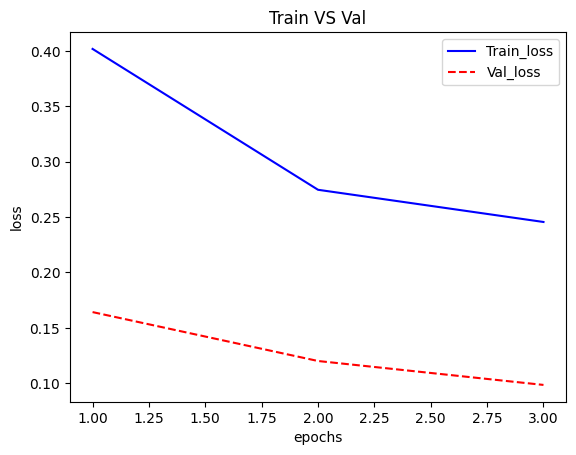

In [29]:
plt.plot([1,2,3] ,train_losses, "b-", label = "Train_loss")
plt.plot([1,2,3], val_losses,"r--", label = "Val_loss")
plt.title("Train VS Val")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

load model

In [30]:
# device = torch.device('cpu')   load model on cpu if you want 
model.load_state_dict(torch.load('/kaggle/working/Best_model.pt' , map_location = device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
get_val_loss()

tensor(0.0986, device='cuda:0')

# Deploy the model